In [1]:
bayesplay::loadpackages()

In [2]:
# 1

# lets generate some data to work with because usually we work with raw data and not summary stats

# statistics reported by Grider and Malmberg (2008) in Rouder et al (2009, pg 232)

# reported values!
sample_size = 80
netural_words = 0.76
positive_words = 0.80
t_stat = 2.24

# calculate the rest from the reported values!
mean_of_difference = positive_words - netural_words
sd_of_difference = (mean_of_difference * sqrt(sample_size)) / t_stat

# generate some data that matches those characteristics

g_m_2008_data = mean_of_difference + sd_of_difference * scale(rnorm(n = sample_size, 0, 1))

glue("Accuracy for positive words was {positive_words}  
Accuracy for neutral words was {netural_words}")%>% IRdisplay::display_markdown()


Accuracy for positive words was 0.8  
Accuracy for neutral words was 0.76

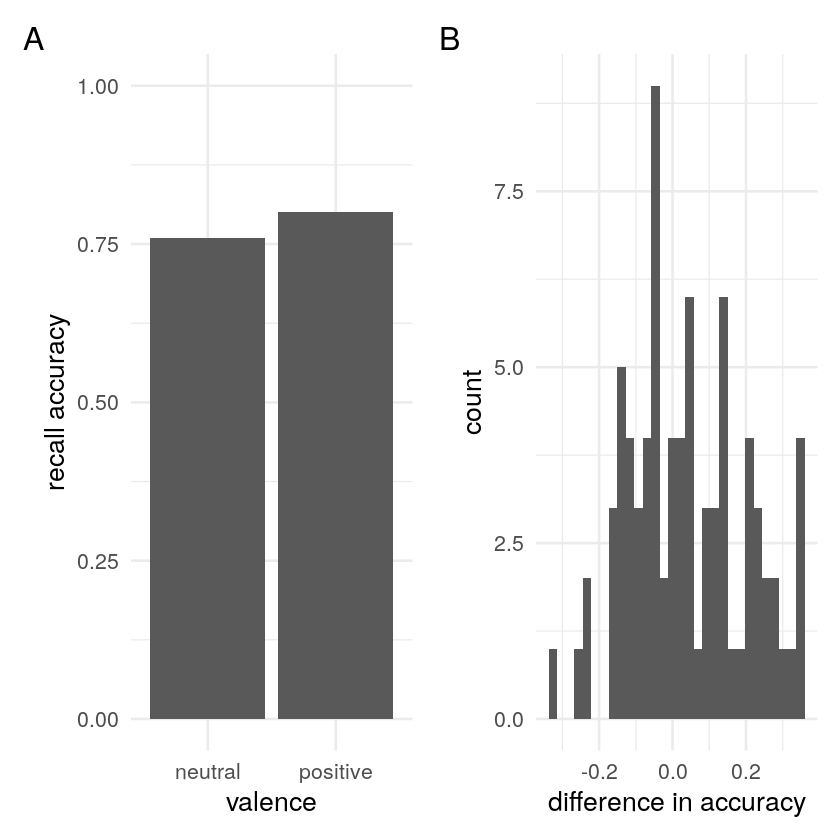

In [3]:
# 2

# lets take a look at the data

plot1 = ggplot(mapping = aes(x = c("neutral","positive"), y = c(netural_words,positive_words))) + 
geom_col() + theme_minimal(16) + scale_y_continuous(name = "recall accuracy", limits = c(0,1)) + 
scale_x_discrete(name = "valence")
plot2 = ggplot(mapping = (aes(x = g_m_2008_data))) + geom_histogram(bins = 30) + 
scale_x_continuous("difference in accuracy") + theme_minimal(16)
plot1 + plot2 + plot_annotation(tag_levels = "A")

In [4]:
# 3

# lets do some analysis!

# first, lets run a *t* test like Grider and Malmberg (2008)
t_test_results = t.test(g_m_2008_data)

# now we'll format them nicely!
t_test_results %>% tidy() %>% 
glue::glue_data("*t* ({parameter}) = {round(statistic,2)}, *p* = {round(p.value,2)}") %>%
IRdisplay::display_markdown()



*t* (79) = 2.24, *p* = 0.03

In [5]:
# 4

# now run a BF analysis with "default" priors

store_bought_bf  = BayesFactor::ttestBF(g_m_2008_data, rscale = 1)
store_bought_bf %>% tidy() %>% glue::glue_data("JZS Bayes factor = {round(BF01,2)}") %>% 
IRdisplay::display_markdown()

JZS Bayes factor = 1.02

In [6]:
# 5
# calculate delta 

delta = mean(g_m_2008_data) / sd(g_m_2008_data)

glue::glue("The observed effect size is {round(delta,2)}") %>% IRdisplay::display_markdown()

The observed effect size is 0.25

In [7]:
# 6 

# Lets set up our likelihood
# we've already calculated the delta which will be the centre
# so we only need the number of data point

# calculate df
df = length(g_m_2008_data) - 1

# define liklihood 

data_model = t.lik(center = delta, df = df)
data_model


Object of class likelihood 
Likelihood type: non-central t 
Parameters
Center: 0.250439613479977
DF: 79

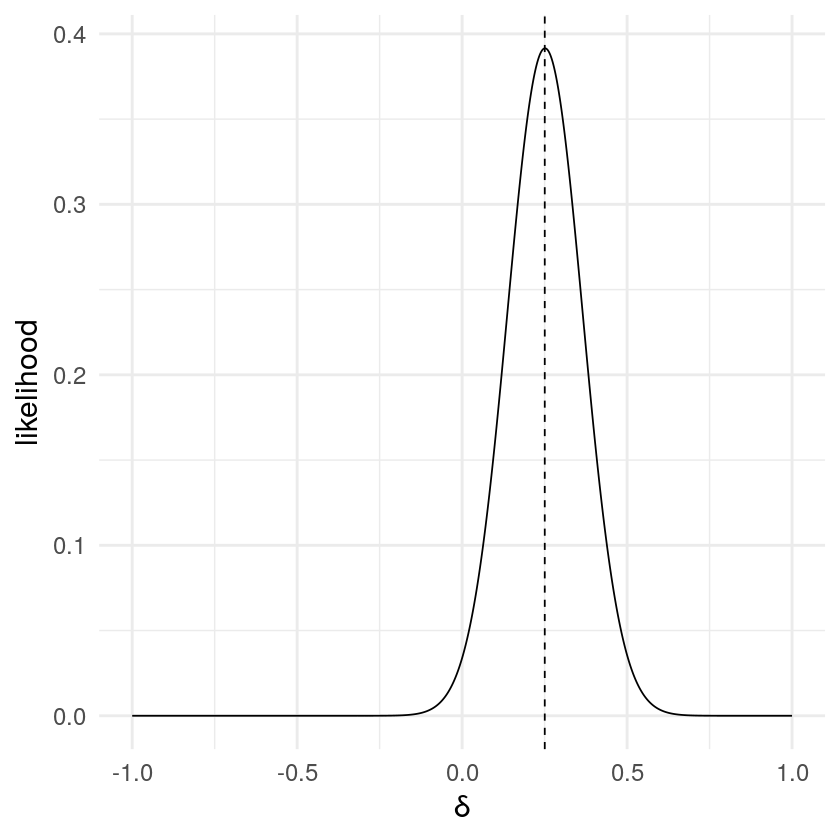

In [8]:
# 7

# Let's plot the likelihood function
# We'll make the plot and then style it with standard ggplot syntax

plot(data_model, theta = seq(from = -1, to = 1,by = 0.001)) + 
    scale_x_continuous(name = "δ") + 
    theme_minimal(18) + 
    geom_vline(xintercept = delta, linetype = 2)

Now that we have our likelihood's we'll need to define our two models. The syntax for defining models is a little clunky, but essentially we just need to give a weighting for every possible value of $\delta$. These should also (ideally) be proper probability distributions. That is, the area under their curves should be **1**. We don't have to worry about this at the moment, because we're using a proper probability distribution. In later analyses we will need to worry about it but luckily **bayesplay** automatically normalises priors so that they're proper. 

Most of our priors are either going to be **normal distributions**, **cauchy distributions**, **uniform distributions**, **t distibutions** or similar. Luckily **R** provides functions for these probability densities. They're are `dnorm()`, `dcauchy()`, `dunif()`, and `dt()` respectively. The basic structure of specifying a prior is as follows:

```r
prior = function(theta.range)
    {
    list(func = function(theta) PRIOR_FUNCTION,
         theta.range = theta.range)
    }
```

In [9]:
# 8

# we'll start by defining the null prior. 
# this is, for all values other than delta = 0, set the weight to 0, and when 
# delta = 0, set the weight to 1

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}

In [10]:
# 9 

# now we define the "alternative" prior
# this will be a standard cauchy distribution

h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

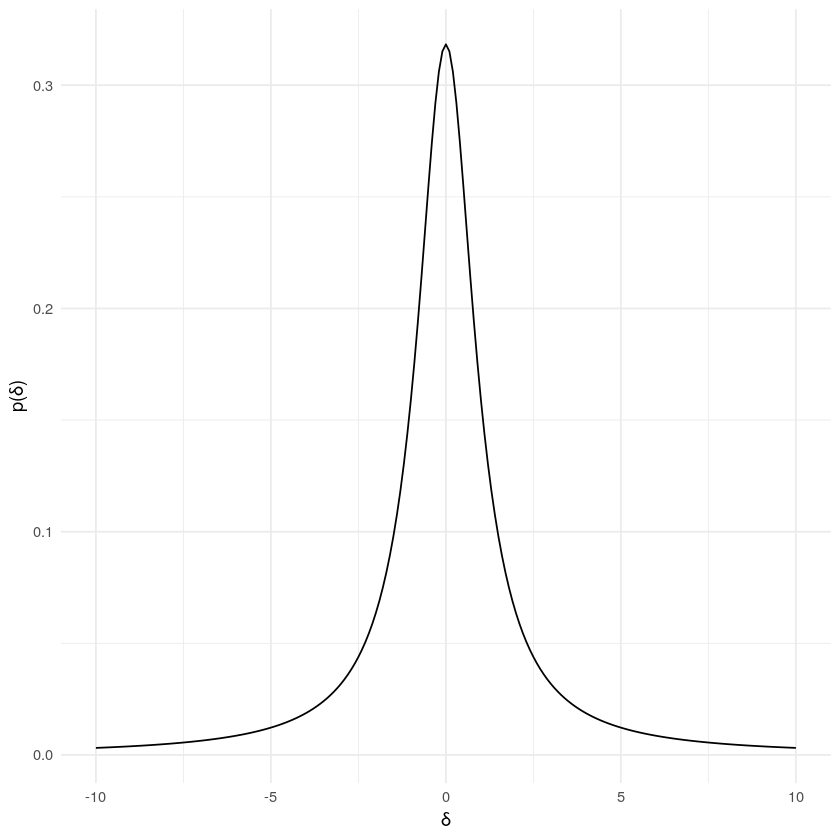

In [11]:
# 10

# plot the prior

# first set the range of values for the plot

theta.range = seq(-10,10,.1) # from -10 to +10 in steps 0.1

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_model(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "δ") + 
scale_y_continuous(name = "p(δ)") + theme_minimal()

In [12]:
# 11

# multiple the prior and likelihood for H_0

M0 = data_model * h0_model(theta.range = c(0,0))
M0

Object of class posterior 
Parameter range: from  0  to  0 
Area under the curve (integral): 0.03386948 
Prior function:  function(theta) ifelse(theta == 0, 1, 0) 
Likelihood function:   

In [13]:
# 12

# multiple the prior and likelihood for H_1

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))
M1

Object of class posterior 
Parameter range: from  -Inf  to  Inf 
Area under the curve (integral): 0.033066 
Prior function:  function(theta) dcauchy(x = theta, location = 0, scale = 1) 
Likelihood function:   

In [14]:
# 13

BF01 = M0$integral / M1$integral
BF01

[1] 1.024299

In [15]:
# 14

glue::glue("The store bought **BF** using the **Bayes factor** package is {round(tidy(store_bought_bf)$BF01,2)}   
The one we made at home is {round(BF01,2)}") %>% IRdisplay::display_markdown()

The store bought **BF** using the **Bayes factor** package is 1.02   
The one we made at home is 1.02

In [16]:
# 15

# calculate observed parameter value
delta = mean(g_m_2008_data) / sd(g_m_2008_data)

# define liklihood 
data_model = t.lik(center = delta, df = length(g_m_2008_data) - 1)

# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}


h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

# multiply the prior and likelihoods and priors

M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))

# take the intergral and divide

BF01 = M0$integral / M1$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}  
B<sub>01</sub> = {round(1/BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 1.02  
B<sub>01</sub> = 0.98

In [17]:
# 16
# calculate observed parameter value
# effect sizes are just t / sqrt(N)
t_value = 2.03
N = 80
delta = t_value / sqrt(N)

# define liklihood 
data_model = t.lik(center = delta, df = N - 1)

# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}


h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

# multiply the prior and likelihoods

M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))

# take the intergral and divide

BF01 =  M0$integral / M1$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}  
B<sub>01</sub> = {round(1/BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 1.56  
B<sub>01</sub> = 0.64

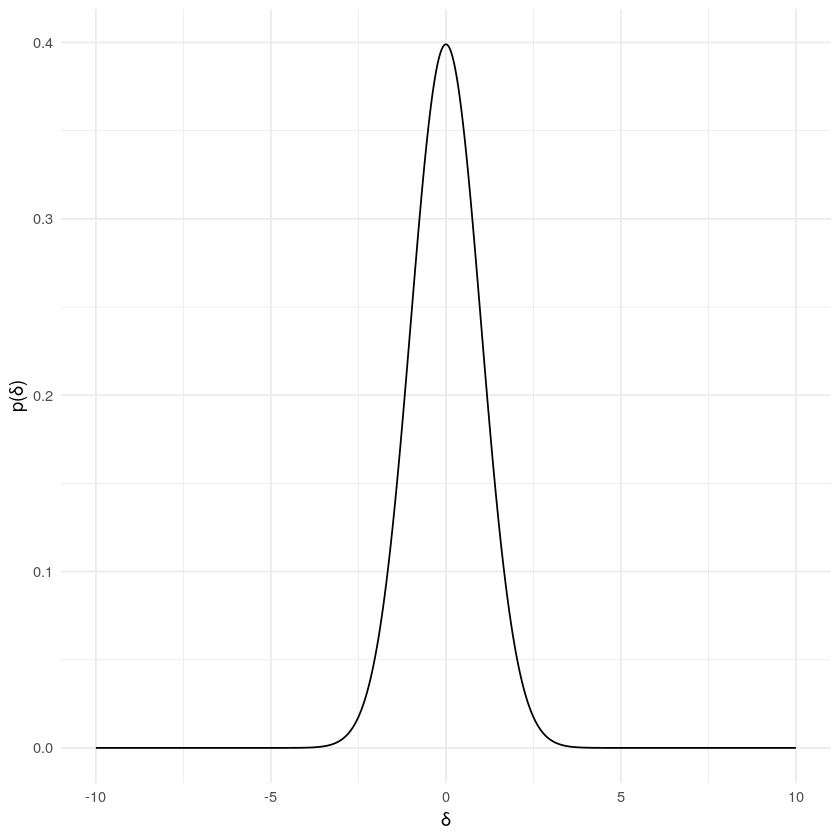

In [18]:
# 17

# define the prior

h1_unit_information = function(theta.range){
    list(func = function(theta) dnorm(x = theta, mean = 0, sd = 1),
         theta.range = theta.range)
}



# plot it over a reasonable range of theta
theta.range = seq(-10,10,.01) 

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_unit_information(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "δ") + 
scale_y_continuous(name = "p(δ)") + theme_minimal()

In [19]:
# 18

M1_unit_info = data_model * h1_unit_information(theta.range = c(-Inf, Inf))

BF01 =  M0$integral / M1_unit_info$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}  
B<sub>01</sub> = {round(1/BF01,2)}") %>% IRdisplay::display_markdown()


B<sub>01</sub> = 1.21  
B<sub>01</sub> = 0.83

In [20]:
# 19

h1_psychic = function(theta.range){
    list(func = function(theta) ifelse(theta == delta, 1, 0) ,
         theta.range = theta.range)
}

M1_psychic = data_model * h1_psychic(theta.range = c(delta, delta))

BF01 =  M0$integral / M1_psychic$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}  
B<sub>01</sub> = {round(1/BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 0.13  
B<sub>01</sub> = 7.55

In [21]:
# 20 

h1_uniform = function(theta.range){
    list(func = function(theta) dunif(x = theta, min = -100, max = 100) ,
         theta.range = theta.range)
}

M1_uniform = data_model * h1_uniform(theta.range = c(-100, 100))

BF01 =  M0$integral / M1_uniform$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}  
B<sub>01</sub> = {round(1/BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 97.42  
B<sub>01</sub> = 0.01

### Dienes (2014) Example 1

In [22]:
# to define the likelihood we'll need the mean and the standard error

negative_mood_acc = 65
positive_mood_acc = 70
mean_diff = abs(negative_mood_acc - positive_mood_acc)
t_stat = 0.5
se = mean_diff / t_stat

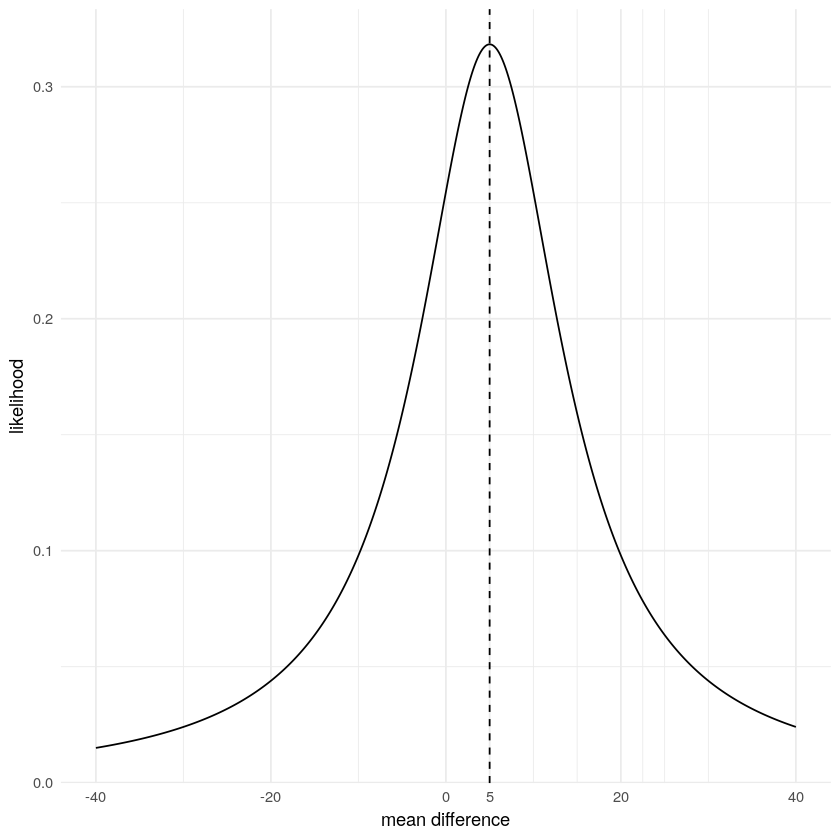

In [23]:
# define the likelihood
# we'll use a normal likelihood
# using a normal might not be the *best* choice, but we'll use it because Dienes (2014) uses a normal
# we can discuss alternatives in subsequent examples

#data_model = norm.lik(center = mean_diff, scale =  se)
data_model = scaled.shifted.t.lik(center = mean_diff, scale =  se, df = 1)


plot(data_model, theta = seq(-40,40,.1)) + geom_vline(xintercept = mean_diff, linetype = 2) + 
scale_x_continuous(name = "mean difference", breaks = c(seq(-40,40,20),mean_diff)) + theme_minimal()

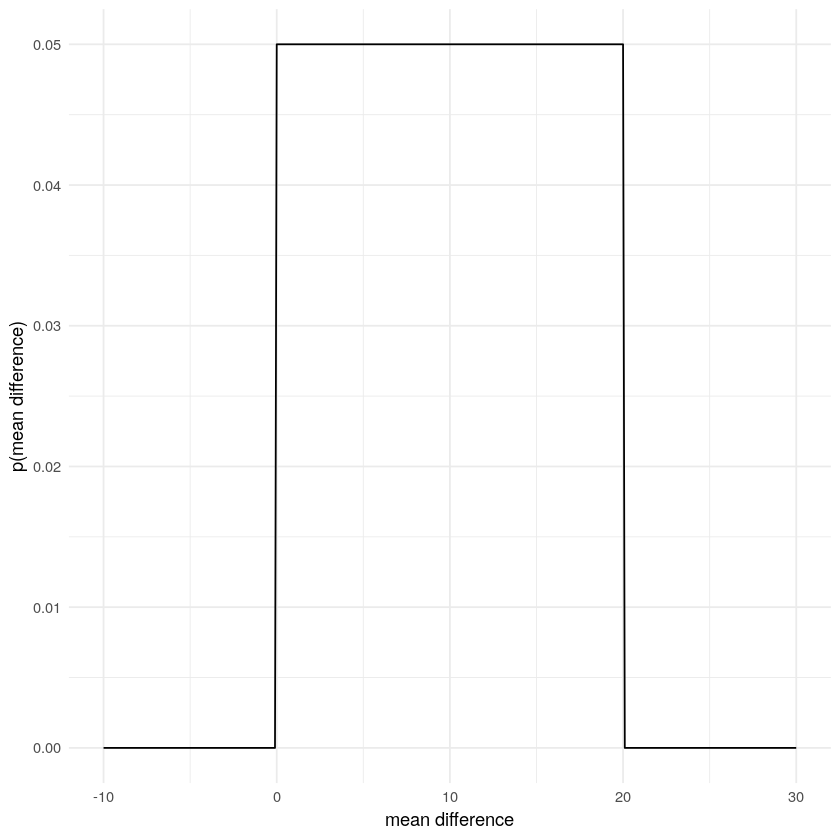

In [24]:
# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0), # a point null with mean diff = 0
         theta.range = theta.range)
}

h1_model = function(theta.range){
    list(func = function(theta) dunif(x = theta, min = 0, max = 20), # uniform prior from 0 to 20
         theta.range = theta.range)
}

# plot the h1 prior 

theta.range = seq(-10,30,.1) # from -10 to +30 in steps 0.1

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_model(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "mean difference") + 
scale_y_continuous(name = "p(mean difference)") + theme_minimal()


In [25]:
# multiply the prior and likelihoods and priors
M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))


BF10 = M1$integral / M0$integral
glue::glue("B<sub>10</sub> = {round(BF10,2)}") %>% IRdisplay::display_markdown()

B<sub>10</sub> = 0.9

Dienes extends the example a bit to show how **BFs** and *p*-values will sometimes lead to different conclusions. It's worth examing the example to understand why this is the case. It'll help us understand both **BFs** and *p*-values better. 

Dienes asks to consider two examples:

1. A mean difference of 1 with a standard error of 10
2. A mean difference of 1 with a standard error of 1

He goes on to calculate *p* values and **BFs** (using the above model<sup>1</sup>) for both example. We'll do the same, and examine the results. 


<sup>1</sup><small>A key point here is that the exact same priors are used for both examples. We might want to question whether this is reasonable.</small>

In [26]:
# Example 1 (t test)

mean_diff = 1
se.1 = 10
df = 50
t_stat.1 = mean_diff / se.1
p_value.1 = 2 * pt(t_stat.1, df,lower.tail = F)

glue::glue("For Example 1, a standard *t* test gives the result: *t*({df}) = {round(t_stat.1,2)}, 
*p* = {round(p_value.1,2)}") %>% 
IRdisplay::display_markdown()

For Example 1, a standard *t* test gives the result: *t*(50) = 0.1, 
*p* = 0.92

In [27]:
# Example 1 with BFs

# We'll use the same priors as before so we just have to change the likelihood (aka data mode)

data_model.1 = norm.lik(center = mean_diff, scale =  se.1)

M0 = data_model.1 * h0_model(theta.range = c(0,0))

M1 = data_model.1 * h1_model(theta.range = c(-Inf, Inf))
BF01.1 = M0$integral / M1$integral
glue::glue("For example 1, the BF analysis gives B<sub>01</sub> = {round(BF01.1,2)}") %>%
IRdisplay::display_markdown()


For example 1, the BF analysis gives B<sub>01</sub> = 1.55

In [28]:
# Example 2 (t test)

mean_diff = 1
se.2 = 1
df = 50
t_stat.2 = mean_diff / se.2
p_value.2 = 2 * pt(t_stat.2, df,lower.tail = F)

glue::glue("For Example 2, a standard *t* test gives the result: *t*({df}) = {round(t_stat.2,2)}, 
*p* = {round(p_value.2,2)}") %>% 
IRdisplay::display_markdown()

For Example 2, a standard *t* test gives the result: *t*(50) = 1, 
*p* = 0.32

In [29]:
# Example 2 with BFs

# We'll use the same priors as before so we just have to change the likelihood (aka data mode)

data_model.2 = norm.lik(center = mean_diff, scale =  se.2)

M0 = data_model.2 * h0_model(theta.range = c(0,0))

M1 = data_model.2 * h1_model(theta.range = c(-Inf, Inf))
BF01.2 = M0$integral / M1$integral
glue::glue("For example 2, the BF analysis gives B<sub>10</sub> = {round(BF01.2,2)}") %>%
IRdisplay::display_markdown()


For example 2, the BF analysis gives B<sub>10</sub> = 5.75

Understanding the difference between these two inferences highlights how the two kinds of analysis ask different questions. Remember, *p* values ask about whether **data are surprising** given a particular parameter. In contrast, **BFs** ask about **plausible values of a parameter**. We can highlight this different by plotting, on the same figure, the range of **unsurprising** data values and the **likely values of the parameter** given our data.

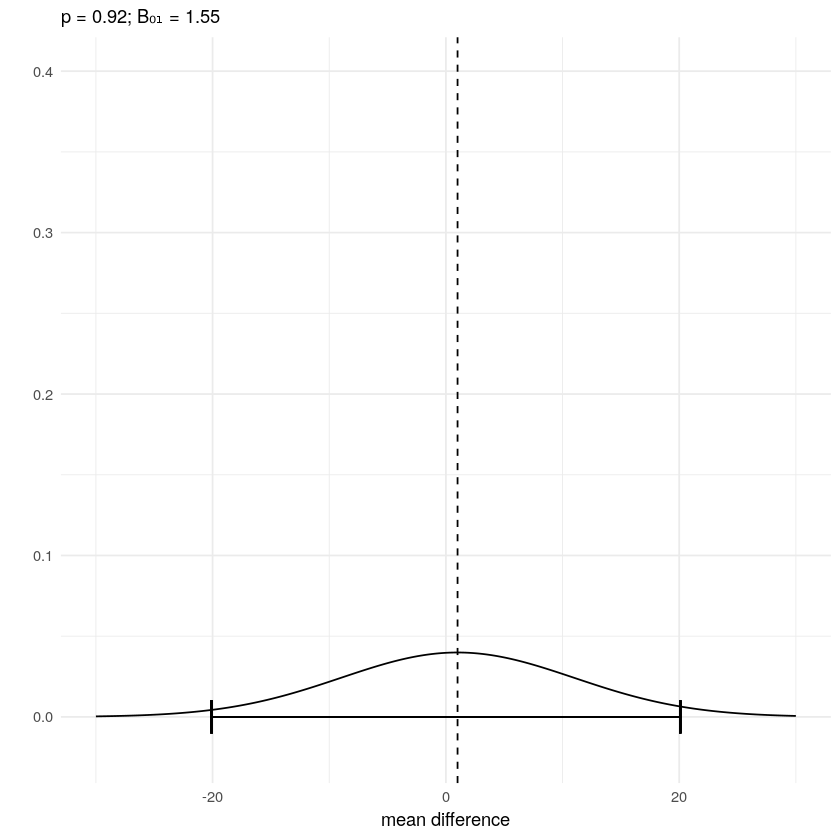

In [30]:
# Example 1

# First get the unsurprising range of data values

# work out the range of unsurprising values in t units
t_range.1 = qt(.975, df = 50, ncp = 0)

# unscale this so that it's in original units
mean_range.1 = t_range.1 * se.1

plot(data_model.1, theta = seq(-30,30,.1)) + ylim(c(-.02,.4)) +
geom_errorbarh(mapping = aes(xmin = -mean_range.1, xmax = mean_range.1, y = 0), height = .02) + 
geom_vline(xintercept = mean_diff, linetype = 2 ) + theme_minimal() +
labs(subtitle = glue::glue("p = {round(p_value.1,2)}; B₀₁ = {round(BF01.1,2)}"), x = "mean difference", y = "")

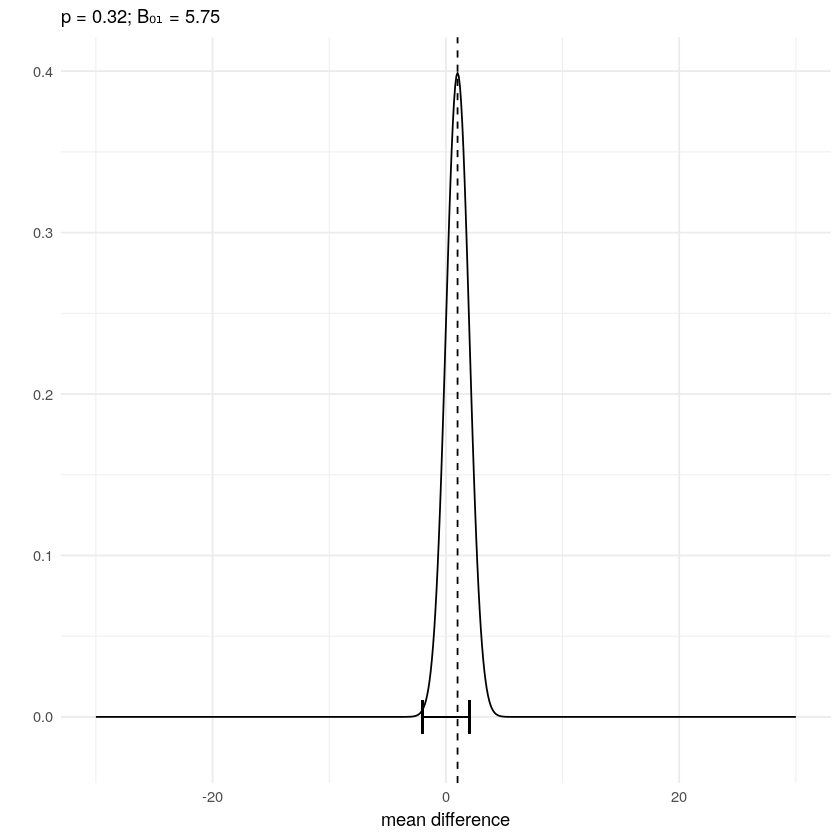

In [31]:
# Example 2

# First get the unsurprising range of data values

# work out the range of unsurprising values in t units
t_range.2 = qt(.975, df = 50, ncp = 0)

# unscale this so that it's in original units
mean_range.2 = t_range.2 * se.2

plot(data_model.2, theta = seq(-30,30,.1))  + ylim(c(-.02,.4)) +
geom_errorbarh(mapping = aes(xmin = -mean_range.2, xmax = mean_range.2, y = 0), height = .02) + 
geom_vline(xintercept = mean_diff, linetype = 2 ) + theme_minimal()  +
labs(subtitle = glue::glue("p = {round(p_value.2,2)}; B₀₁ = {round(BF01.2,2)}"), x = "mean difference", y = "")

In the plots we can see that in example 1, a very wide range of values of the mean difference could plausibly produce the value of the mean difference we actually observed. In example 2, however, the range of plausible values for the mean difference is very small. In example 1, the range of values includes values that are both very big and very small. That is, data show that we're very uncertain about the actual value of the mean difference with the likelihood being wide and spread out; therefore, the BF value does allow us to make any strong conclusions either way about which model is best supported. In example 2, however, the range is narrow and all the values are very close to 0 (our null value)—that is, the likelihood is highly peaked near 0.

The frequentist inference asks something completely different. We set the paramter to 0, and then generate data based on this. We compare this generated data with our actual data and ask if it's surprising or not. From the first plot, we see that the "unsurprising" range is very large. Our data lies somewhere near the middle of the range. In the second figure, the range is very narrow. As a result, our data now lies right near the edge of the range. 

Again, because this is not a class on frequentist inference I won't give details on what I think the **correct** frequentist analysis for these example should be. But these examples are illustrative because they employ the **common** way **most people** would analyse this kind data.